<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/Akash/CIFAR_10_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import models, layers
from sklearn.metrics import accuracy_score

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2021-02-10 19:18:12--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  51.5MB/s    in 3.5s    

2021-02-10 19:18:16 (46.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
!mkdir ./cifar_10/
!tar -xf cifar-10-python.tar.gz -C ./cifar_10/
!rm -rf cifar-10-python.tar.gz

In [4]:
!ls -l ./cifar_10/cifar-10-batches-py/

total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [5]:
workdir = os.curdir
datadir = os.path.join(workdir,'cifar_10','cifar-10-batches-py')
train_files = [os.path.join(datadir,f'data_batch_{i}') for i in range(1,6)]
test_file = 'test_batch'

In [6]:
# unpickle the data file containing the image
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
data_dict = unpickle(train_files[0])
data_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
# read all files into a dataset
data = np.empty(data_dict[b'data'].shape)
labels = list()
for fl in train_files:
  print(f"Loading File {fl}")
  df = unpickle(fl)
  print(df[b'batch_label'])
  print(f"Geting Data")
  if df[b'batch_label'] == b'training batch 1 of 5':
    data = df[b'data']
  else:
    data = np.concatenate([data,df[b'data']])
  print("Geting labels")
  labels = labels + df[b'labels']
  print(f"Shape of Data is {data.shape}")
  print("="*50)

Loading File ./cifar_10/cifar-10-batches-py/data_batch_1
b'training batch 1 of 5'
Geting Data
Geting labels
Shape of Data is (10000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_2
b'training batch 2 of 5'
Geting Data
Geting labels
Shape of Data is (20000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_3
b'training batch 3 of 5'
Geting Data
Geting labels
Shape of Data is (30000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_4
b'training batch 4 of 5'
Geting Data
Geting labels
Shape of Data is (40000, 3072)
Loading File ./cifar_10/cifar-10-batches-py/data_batch_5
b'training batch 5 of 5'
Geting Data
Geting labels
Shape of Data is (50000, 3072)


In [9]:
# Reading Metadata
label_meta = unpickle(os.path.join(datadir,'batches.meta'))[b'label_names']
label_meta_mapping = {i:label_meta[i].decode('utf-8') for i in range(len(label_meta))}
label_meta_mapping

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [10]:
labels = np.array(labels)
for i in range(0,10):
  lb_count = np.sum((labels == i)*1)
  print(f"{label_meta_mapping[i]}: {lb_count}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [11]:
data_rgb = np.reshape(data, (data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

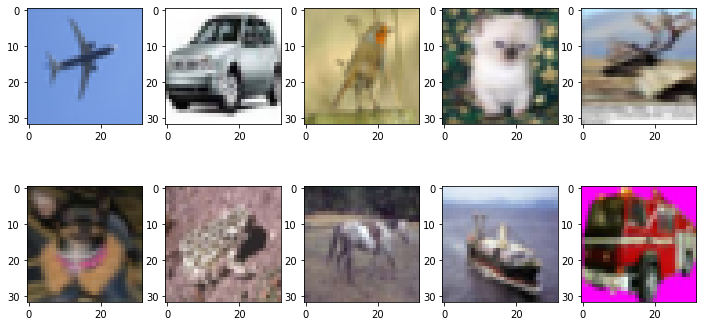

In [12]:
rnd_idx = np.random.randint(1,5000)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
for i in range(10):
  samp = data_rgb[labels == i][rnd_idx,:,:,:]
  ax[int(i/5)][i%5].imshow(samp)

In [13]:
X = data_rgb/255
lb_bin = LabelBinarizer().fit(np.array(labels))
y = lb_bin.transform(np.array(labels))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.7)
print(f"Training Data Size : {train_X.shape[0]}")
print(f"Validation Data Size : {val_X.shape[0]}")
print(f"Testing Data Size : {test_X.shape[0]}")

Training Data Size : 40000
Validation Data Size : 7000
Testing Data Size : 3000


In [14]:
def Residual_Layer(input_layer, filters, stride):
  # Main Branch
  x1 = tf.keras.layers.Conv2D(filters=filters, kernel_size = 3, strides=strd, padding = 'same')(input_layer)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation('relu')(x1)
  x1 = tf.keras.layers.Conv2D(filters=filters, kernel_size = 3, strides=1, padding =  'same')(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation('relu')(x1)
  end_layer = x1
  # Skip Branch
  if stride > 1:
    x2 = tf.keras.layers.Conv2D(filters=filters, kernel_size = 1, strides=strd, padding =  'same')(input_layer)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Activation('relu')(x2)
    end_layer = tf.keras.layers.add([x1, x2])
  return end_layer

In [15]:
LRN_Layer = tf.keras.layers.Lambda(tf.nn.local_response_normalization)

In [54]:
inputs = tf.keras.Input(shape=train_X.shape[1:])

x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
  strd = 1 if filters == prev_filters else 2
  x = Residual_Layer(x, filters, strd)
  prev_filters = filters

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dropout(0.6)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [55]:
#%tensorflow_version 2.x
#device_name = tf.test.
#if device_name != '/device:TPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [56]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.build(input_shape=train_X.shape[1:])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_257 (Conv2D)             (None, 16, 16, 64)   9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_257 (BatchN (None, 16, 16, 64)   256         conv2d_257[0][0]                 
__________________________________________________________________________________________________
activation_257 (Activation)     (None, 16, 16, 64)   0           batch_normalization_257[0][0]    
____________________________________________________________________________________________

In [51]:
erly_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True,
)

model_monit = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(os.curdir), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min'
)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.1, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [52]:
"""
base_model = tf.keras.applications.ResNet152(include_top=False, input_shape=train_X.shape[1:], weights=None)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = tf.keras.layers.Dense(10, activation='softmax')(avg)
model = tf.keras.Model(base_model.inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
"""

"\nbase_model = tf.keras.applications.ResNet152(include_top=False, input_shape=train_X.shape[1:], weights=None)\navg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)\noutputs = tf.keras.layers.Dense(10, activation='softmax')(avg)\nmodel = tf.keras.Model(base_model.inputs, outputs)\nmodel.compile(optimizer='adam',\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\nmodel.summary()\n"

In [53]:
history = model.fit(x=train_X, y=train_y, batch_size=64, epochs=100, validation_data=(val_X, val_y),
                    callbacks=[erly_stop, model_monit])

Epoch 1/100
625/625 [==============================] - 24s 38ms/step - loss: 2.3653 - accuracy: 0.1018 - val_loss: 849462.0625 - val_accuracy: 0.1039
Epoch 2/100
625/625 [==============================] - 24s 38ms/step - loss: 2.3542 - accuracy: 0.1017 - val_loss: 399294.6875 - val_accuracy: 0.1000
Epoch 3/100
167/625 [=======>......................] - ETA: 16s - loss: 2.3491 - accuracy: 0.0974

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_X, test_y)

94/94 [==============================] - 2s 23ms/step - loss: 1.8050 - accuracy: 0.6913


[1.8050097227096558, 0.6913333535194397]

In [ ]:
def top_5_error_rate(predict_proba, y_true):
  result = 0
  for i in range(len(y_true)):
    row = predict_proba[i,:]
    top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
    if np.argmax(y_true[i]) in top_5:
      result = result + 1
  
  return result/len(y_true)

In [ ]:
proba = model.predict(test_X)
print(f'Accuracy Score : {model.evaluate(test_X, test_y)}')
print(top_5_error_rate(proba, test_y))

94/94 [==============================] - 2s 22ms/step - loss: 1.8050 - accuracy: 0.6913
Accuracy Score : [1.8050097227096558, 0.6913333535194397]
0.962


In [ ]:
test_batch = unpickle(os.path.join(datadir,'test_batch'))
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

In [ ]:
test_data = np.reshape(test_data, (test_data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

'airplane'

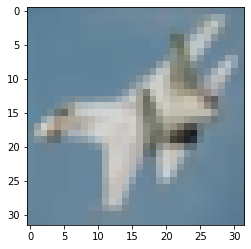

In [ ]:
idx = np.random.randint(200)
plt.imshow(test_data[idx])
label_meta_mapping[test_labels[idx]]

In [ ]:
proba_test = model.predict(test_data/255)
y_test_bat = lb_bin.transform(np.array(test_labels))
print(f'Accuracy Score : {model.evaluate(test_data/255, y_test_bat)}')
print(top_5_error_rate(proba_test, y_test_bat))

313/313 [==============================] - 7s 22ms/step - loss: 1.7557 - accuracy: 0.6854
Accuracy Score : [1.7556718587875366, 0.6854000091552734]
0.9606


Acutal Label: frog
Predicted Label: frog
{'frog': 0.9836076, 'airplane': 0.009326594, 'dog': 0.005141229, 'automobile': 0.0010521332}


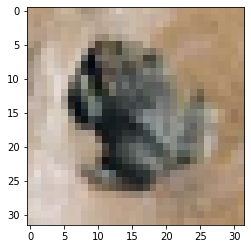

In [ ]:
idx = np.random.randint(1000)
prediction = proba_test[idx]
prediction_label = label_meta_mapping[np.argmax(prediction)]
actual = label_meta_mapping[test_labels[idx]]
print(f"Acutal Label: {actual}\nPredicted Label: {prediction_label}")
row = prediction
top_5 = sorted(range(len(row)), key = lambda x: row[x], reverse=True)[:5]
top_5 = [label_meta_mapping[i] for i in top_5]
top_5 = dict(zip(top_5, list(np.sort(prediction))[-1:-5:-1]))
print(top_5)
fig = plt.imshow(test_data[idx])